In [1]:
import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize

In [2]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""

    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                     for a in self.args)

    def __repr__(self):
       return '\n\n'.join(a + '\n' + repr(eval(a))
                       for a in self.args)

In [3]:
indir_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_stop_track_muon/Inference/pid_Leon_RD_results_new_model.csv"
indir_MC = "/groups/icecube/peter/storage/Multiclassification/Real/last_one_lvl3MC/dynedge_pid_Real_run_21.5_mill_equal_frac_second_/results.csv"
outdir = "/groups/icecube/qgf305/workspace/analyses/multi_classification_on_stop_and_track_muons/plotting/Comparison_RD_MC/test"

results_RD = pd.read_csv(indir_RD, index_col=[0])
results_MC = pd.read_csv(indir_MC, index_col=[0])

In [4]:
print(np.unique(results_MC.pid))
pid_transform = {1:0,12:2,13:1,14:2,16:2}

[-16. -14. -12.  -1.  12.  13.  14.  16.]


In [5]:
display("results_RD", "results_MC")

,pid_noise_pred,pid_muon_pred,pid_neutrino_pred,pid,event_no
0,9.100197e-04,0.995220,3.870316e-03,-1.0,0.0
1,1.982298e-17,0.999997,3.332041e-06,-1.0,1.0
2,2.132605e-12,0.999917,8.263976e-05,-1.0,2.0
3,2.653166e-14,0.999795,2.045055e-04,-1.0,3.0
4,9.950417e-01,0.000308,4.650586e-03,-1.0,4.0
...,...,...,...,...,...
1420704,9.957962e-01,0.000621,3.582841e-03,-1.0,96917756.0
1420705,2.507694e-17,1.000000,4.941842e-07,-1.0,96917757.0
1420706,1.000000e+00,0.000000,0.000000e+00,-1.0,96917758.0
1420707,9.853759e-01,0.001128,1.349629e-02,-1.0,96917759.0


In [6]:
truth_MC = []

for i in range(len(results_MC)):# range(len(results)):
    truth_MC.append(pid_transform[abs(results_MC['pid'].values[i])])

In [7]:
def to_logit(p):
    try:
        logit = np.log(p/(1-p))
    except ZeroDivisionError:
        logit = 0
    if np.isinf(logit):
        logit = 0
    return logit

In [8]:
logits = dict()
for item in ["noise", "muon", "neutrino"]:
    logits[item] = results_MC[f"pid_{item}_pred"].apply(to_logit)

In [9]:
logits = pd.DataFrame.from_dict(logits)

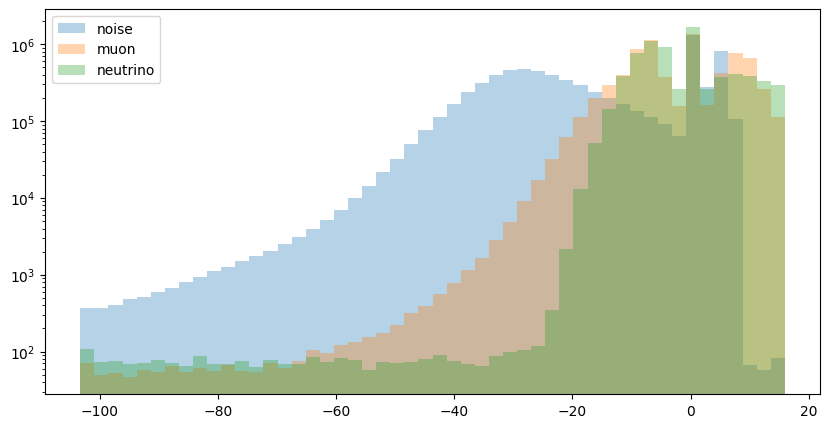

In [10]:
fix, ax = plt.subplots(figsize=[10, 5])
for item in ["noise", "muon", "neutrino"]:
    ax.hist(logits[item], bins=50, alpha=0.33, label=item);
ax.set(yscale="log")
ax.legend();

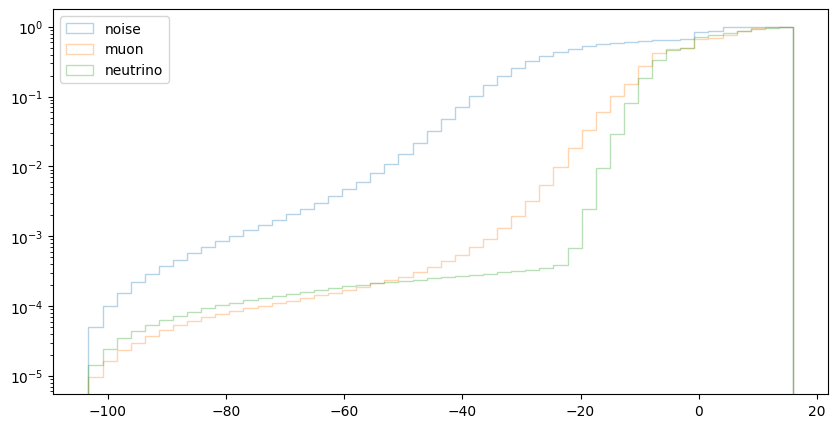

In [11]:
fix, ax = plt.subplots(figsize=[10, 5])
for item in ["noise", "muon", "neutrino"]:
    ax.hist(logits[item], bins=50, alpha=0.33, label=item, cumulative=True, histtype='step', density=True);
ax.set(yscale="log")
ax.legend(loc="upper left");

In [12]:
stds = dict()
means = dict()
for item in ["noise", "muon", "neutrino"]:
    stds[item] = logits[item].std()
    means[item] = logits[item].mean()

stds = pd.DataFrame.from_dict(stds, orient='index', columns=['std'])
means = pd.DataFrame.from_dict(means, 'index', columns=['mean'])

metrics = pd.concat([stds,means],axis=1)
display("metrics")

,std,mean
noise,16.360558,-16.625953
muon,8.815463,-2.003995
neutrino,7.530003,-1.146454


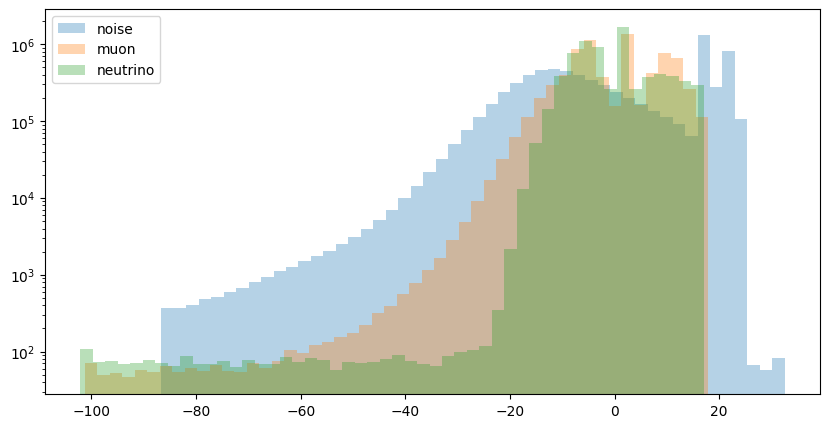

In [63]:
fix, ax = plt.subplots(figsize=[10, 5])
for i, item in enumerate(["noise", "muon", "neutrino"]):
    ax.hist(logits[item]-metrics["mean"][i], bins=50, alpha=0.33, label=item);
ax.set(yscale="log")
ax.legend();

In [1]:
def inverse_logit(p):
    try:
        logit = np.log(1/(1+np.exp(-p)))
    except ZeroDivisionError:
        logit = 0
    if np.isinf(logit):
        logit = 0
    return logit

In [71]:
logits2 = dict()
for item in ["noise", "muon", "neutrino"]:
    logits2[item] = results_MC[f"pid_{item}_pred"].apply(inverse_logit)

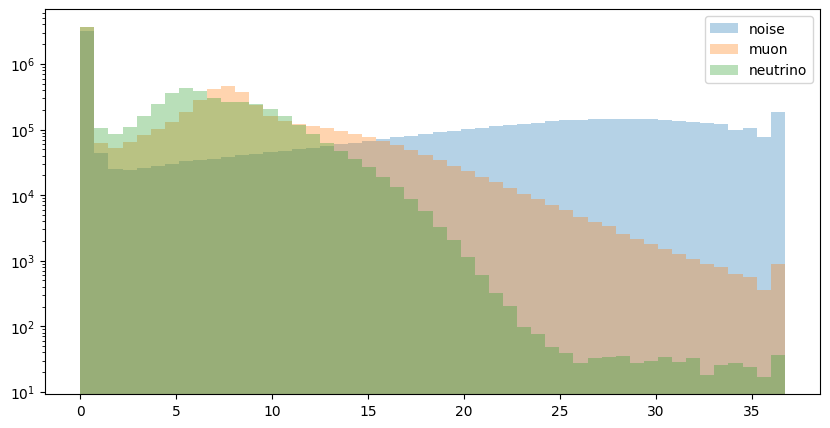

In [72]:
fix, ax = plt.subplots(figsize=[10, 5])
for i, item in enumerate(["noise", "muon", "neutrino"]):
    ax.hist(logits2[item], bins=50, alpha=0.33, label=item);
ax.set(yscale="log")
ax.legend();

In [ ]:
def to_multivariate_logit(p1,p2):
    """bivariate logit with common metrics"""
    try:
        sigma =
        rho =
        mu = 
        p1_logit = to_logit(p1)
        p2_logit = to_logit(p2)
        Q = (sigma**2 * (1-rho**2))**(-1) * ( (p1_logit-mu)**2 + (p2_logit-mu)**2 - 2*rho * (p1_logit-mu)*(p2_logit-mu))
        sub = (sigma**2 * np.sqrt(1-rho) * p1 * p2 * (1-p1)*(1-p2))
        upper = np.exp(-Q*0.5)
        logit = upper/sub
    except ZeroDivisionError:
        logit = 0
    if np.isinf(logit):
        logit = 0
    return logit